In [89]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
import numpy as np

from data_utils import get_model, get_data

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_name = "clip_res"
clip_model, clip_prep = get_model(clip_name, device)
cvcl_name = "cvcl_res" 
cvcl_model, cvcl_prep = get_model(cvcl_name, device)

Loading CLIP
Loading CVCL


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

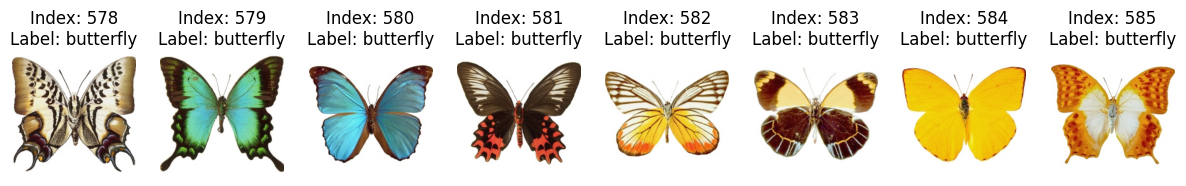

In [124]:
def get_image_indices_by_label(dataset, label, num_images=5):
    class_id = dataset.class_to_idx[label]
    indices = [i for i, (_, target) in enumerate(dataset) if target == class_id]
    return indices[:num_images]

def show_images_by_indices(dataset, indices):
    fig, axs = plt.subplots(1, len(indices), figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, class_id = dataset[idx]
        axs[i].imshow(np.array(image))
        axs[i].set_title(f"Index: {idx}\nLabel: {dataset.classes[class_id]}")
        axs[i].axis('off')
    plt.show()

data = get_data("konk")
label = "butterfly"  
indices = get_image_indices_by_label(data, label, num_images=8)
show_images_by_indices(data, indices)

In [127]:

# Prepare the inputs
image, class_id = data[582]
clip_img_input = clip_prep(image).unsqueeze(0).to(device)
#TODO replace with baby vocab? 
clip_txt_input = torch.cat([clip.tokenize(f"a photo of a {c}") for c in data.classes]).to(device)

# CLIP
with torch.no_grad():
    clip_image_features = clip_model.encode_image(clip_img_input)
    clip_text_features = clip_model.encode_text(clip_txt_input)

# similarity
clip_image_features /= clip_image_features.norm(dim=-1, keepdim=True)
clip_text_features /= clip_text_features.norm(dim=-1, keepdim=True)
clip_similarity = (100.0 * clip_image_features @ clip_text_features.T).softmax(dim=-1)
clip_values, clip_indices = clip_similarity[0].topk(5)

# CVCL
cvcl_img_input = cvcl_prep(image).unsqueeze(0).to(device)
tokenized_results = [cvcl_model.tokenize(f"a photo of {c}") for c in data.classes]
tokens_list = [result[0] for result in tokenized_results]
lengths_list = [result[1] for result in tokenized_results]

texts = torch.cat(tokens_list).to(device)
texts_len = torch.cat(lengths_list).to(device)

with torch.no_grad():
    cvcl_image_features = cvcl_model.encode_image(cvcl_img_input)
    cvcl_text_features = cvcl_model.encode_text(texts, texts_len)

cvcl_image_features /= cvcl_image_features.norm(dim=-1, keepdim=True)
cvcl_text_features /= cvcl_text_features.norm(dim=-1, keepdim=True)
cvcl_similarity = (100.0 * cvcl_image_features @ cvcl_text_features.T).softmax(dim=-1)
cvcl_values, cvcl_indices = cvcl_similarity[0].topk(5)

# 打印预测结果
print("\nCLIP Top predictions:\n")
clip_predictions = []
for value, index in zip(clip_values, clip_indices):
    label = data.classes[index]
    clip_predictions.append((label, 100 * value.item()))
    print(f"{label:>16s}: {100 * value.item():.2f}%")

print("\nCVCL Top predictions:\n")
cvcl_predictions = []
for value, index in zip(cvcl_values, cvcl_indices):
    label = data.classes[index]
    cvcl_predictions.append((label, 100 * value.item()))
    print(f"{label:>16s}: {100 * value.item():.2f}%")



CLIP Top predictions:

        bathsuit: 96.39%
        coatrack: 0.38%
           clock: 0.34%
    babycarriage: 0.34%
        backpack: 0.29%

CVCL Top predictions:

  jack-o-lantern: 80.67%
       butterfly: 11.34%
            tree: 7.62%
           spoon: 0.17%
          leaves: 0.07%


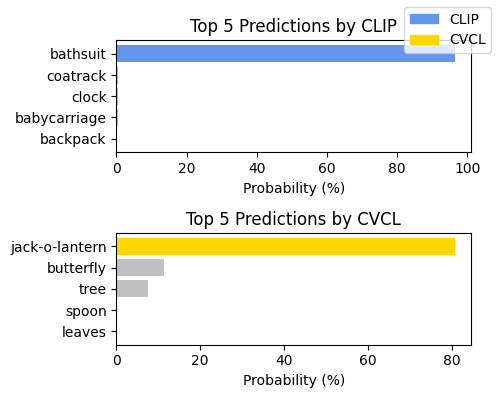

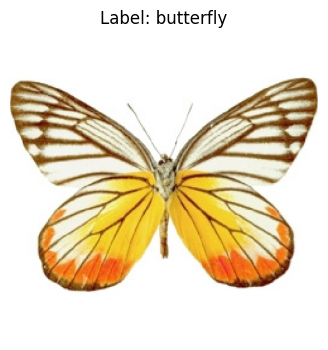

In [128]:
import matplotlib.patches as mpatches
import matplotlib.image as mpimg

# 显示预测结果
fig, axs = plt.subplots(2, 1, figsize=(5, 4))  # 两个子图上下组合

# 定义颜色
clip_color = 'cornflowerblue'
cvcl_color = 'gold'
gray_color = 'silver'

# 显示CLIP预测结果
clip_labels = [x[0] for x in clip_predictions]
clip_values = [x[1] for x in clip_predictions]
clip_colors = [clip_color if i == 0 else gray_color for i in range(len(clip_labels))]  # 最大值为clip_color，其余为灰色

axs[0].barh(np.arange(len(clip_labels)), clip_values, color=clip_colors)
axs[0].set_yticks(np.arange(len(clip_labels)))
axs[0].set_yticklabels(clip_labels)
axs[0].invert_yaxis()  # 标签从上到下排列
axs[0].set_xlabel('Probability (%)')
axs[0].set_title('Top 5 Predictions by CLIP')

# 显示CVCL预测结果
cvcl_labels = [x[0] for x in cvcl_predictions]
cvcl_values = [x[1] for x in cvcl_predictions]
cvcl_colors = [cvcl_color if i == 0 else gray_color for i in range(len(cvcl_labels))]  # 最大值为cvcl_color，其余为灰色

axs[1].barh(np.arange(len(cvcl_labels)), cvcl_values, color=cvcl_colors)
axs[1].set_yticks(np.arange(len(cvcl_labels)))
axs[1].set_yticklabels(cvcl_labels)
axs[1].invert_yaxis()  # 标签从上到下排列
axs[1].set_xlabel('Probability (%)')
axs[1].set_title('Top 5 Predictions by CVCL')

# 添加图例
clip_patch = mpatches.Patch(color=clip_color, label='CLIP')
cvcl_patch = mpatches.Patch(color=cvcl_color, label='CVCL')
plt.figlegend(handles=[clip_patch, cvcl_patch], loc='upper right', ncol=1)

# fig.set_size_inches(7, 6) 

plt.tight_layout()

# # 保存图表图到缓冲区
# import io
# buf = io.BytesIO()
# fig.savefig(buf, format='png')
# buf.seek(0)

# # 创建一个新的图像，包含图表图和原始图片
# fig_combined, ax_combined = plt.subplots(1, 2, figsize=(16, 10))  # 创建一个包含两个子图的图像

# # 加载缓冲区中的图表图像
# chart_image = mpimg.imread(buf)
# ax_combined[1].imshow(chart_image)
# ax_combined[1].axis('off')  # 关闭坐标轴

# # 在第二个子图中绘制原始图片
# ax_combined[0].imshow(image)
# ax_combined[0].set_title(f"Label: {cifar100.classes[class_id]}")
# ax_combined[0].axis('off')  # 关闭坐标轴

fig, img = plt.subplots(1, 1, figsize=(4, 4))
img.imshow(image)
img.set_title(f"Label: {data.classes[class_id]}")
img.axis('off')

plt.show()
plt.show()